#### **Approach**

First, I searched for real-world data and found a 7,000-row unlabeled dataset ([animal-fun-facts](https://github.com/ekohrt/animal-fun-facts-dataset)). This gave me the idea to label and then augment this data with synthetic examples, then test the resulting model on another real-world dataset to evaluate its generalization capability.

I initially created a few dozen examples using ChatGPT, but they turned out too similar. Simple prompts produced grammatically correct but overly uniform data, which wouldn’t help the model perform well in real-world scenarios. To improve synthetic NER data generation, I looked for better methods and found a research [paper](https://arxiv.org/pdf/2403.11103v1). This approach enhances the diversity and quality of generated data, potentially leading to better model performance. The framework involves two main parts: generating attribute categories for examples and pools of entities for these attributes, then creating examples using entities sampled from the pools. I also found that simply asking an LLM to generate NER examples with a list of tags wasn’t effective, and the method from the paper didn’t work well for my task either. As a result, I developed my own format to label the generated data. The synthetic part was generated and labeled using Llama-3.3-70B.

Third, when I read the task, I remembered the MS COCO dataset, which provides captions for pictures. I think this is a good fit as a test dataset for the task.

#### **Summary**

In the end, I obtained three datasets:
- Labeled by LLM and filtered animal-fun-facts (~600 examples)
- Synthetic (~1,900 examples)
- Labeled manually and filtered MS COCO (~150 examples)



#### **1.** `synthetic`

The main idea is to first generate attributes and pools of attribute values, and then create examples based on these attributes.

Generating Attributes and Attribute Values:
- https://chatgpt.com/share/67c2a7ec-7194-8001-a5be-d6164d3cb2ef

In [9]:
attributes = {
    "writing_style": [
        "Descriptive", "Narrative", "Expository", "Poetic", "Humorous"
    ],
    "context": [
        "Natural habitat", "Domesticated setting", "Mythological or fictional world", 
        "Scientific study", "Folklore or legend"
    ],
    "action_or_behavior": [
        "Hunting or foraging", "Social interaction", "Resting or sleeping", 
        "Playing or exploring", "Defending territory"
    ],
}


animal_terms = {
    "butterfly": ["butterfly", "flutterer", "lepidopteran", "winged insect", "moth-like creature"],
    "cat": ["cat", "feline", "kitten", "tomcat", "pussycat", "moggy", "house cat"],
    "chicken": ["chicken", "hen", "rooster", "cock", "cockerel", "chick", "poultry", "fowl"],
    "cow": ["cow", "cattle", "heifer", "bull", "ox", "bovine", "calf", "steer"],
    "dog": ["dog", "canine", "puppy", "hound", "mutt", "pooch", "cur", "fido"],
    "elephant": ["elephant", "pachyderm", "tusker", "jumbo", "bull elephant", "cow elephant", "calf"],
    "horse": ["horse", "equine", "stallion", "mare", "foal", "colt", "filly", "pony", "nag", "gelding"],
    "sheep": ["sheep", "ovine", "lamb", "ram", "ewe", "mutton"],
    "spider": ["spider", "arachnid", "web-spinner", "creepy-crawler", "tarantula", "orb-weaver"],
    "squirrel": ["squirrel", "rodent", "tree-climber", "bushy-tail", "sciurid"]
}

animal_terms_list = [term for terms in animal_terms.values() for term in terms]

animal_kinds = [kind.upper() for kind in animal_terms.keys()]


In [44]:
from dotenv import dotenv_values, load_dotenv
load_dotenv()
config = dotenv_values(".env")

I used LangChain to generate sentences with the Groq API (since it’s free). For credentials, I’m using dotenv to load them from a `.env` file.

In [45]:
from langchain_groq import ChatGroq

llm = ChatGroq(
    model="llama-3.3-70b-versatile",
    temperature=0.6,
    max_tokens=None,
)

The simpler the answer format, the lower the chance of LLM hallucinations. I asked the LLM to label data with `[KIND]...[KIND]` tags. This approach is cheaper and more reliable than using JSON or other formats.

In [46]:
from langchain_core.prompts import (
    ChatPromptTemplate,
    SystemMessagePromptTemplate,
    HumanMessagePromptTemplate,
)
from langchain_core.runnables import RunnableLambda


system_prompt = """Suppose you are writer."""

input_prompt = """Please generate synthetic sentences with animal kinds. Please surround all animal kinds with specific tokens: [KIND] before and [KIND] after, where KIND is one of {animal_kinds}.

Here are some example sentences and annotations for your reference. Please follow this format.
Examples:
The [DOG]hound[DOG] chased a rabbit through the dense forest.
A majestic [ELEPHANT]tusker[ELEPHANT] roamed the African plains at sunset.
The [SQUIRREL]bushy-tail[SQUIRREL] darted across the park, searching for hidden nuts.

Additionally, the generated sentences should follow the requirements below:
1. The writing style of the sentences should be {writing_style}.
2. The sentences should be written from {context} perspective.
3. The sentences should describe {action_or_behavior} of the animal.

Generate 15 sentences with words {animals}.

In answer give me only generated sentences separated by '\n' symbol."""

prompt = ChatPromptTemplate.from_messages(
        [
            SystemMessagePromptTemplate.from_template(
                template=system_prompt,
            ),
            HumanMessagePromptTemplate.from_template(
                template=input_prompt, 
                input_variables=["animal_kinds", "writing_style", "context", "action_or_behavior", "animals"],
            ),
        ]
    )

parser = RunnableLambda( lambda x: x.content.split('\n'))

generation_chain = (
    prompt
    | llm
    | parser
)


Generate examples attributes combinations.

In [47]:
from itertools import product

cartesian_product = list(product(attributes["writing_style"], attributes["context"], attributes["action_or_behavior"]))
len(cartesian_product)

125

Dataset generation.

In [51]:
from tqdm import tqdm
import random
from time import sleep

generated_examples = []

for attributes in tqdm(cartesian_product):
    generated_examples += generation_chain.invoke({
        "animal_kinds": animal_kinds, 
        "writing_style": attributes[0], 
        "context": attributes[1], 
        "action_or_behavior": attributes[2], 
        "animals": random.sample(animal_terms_list, 15)
        })
    sleep(5)

len(generated_examples)

100%|██████████| 125/125 [18:26<00:00,  8.85s/it] 


1945

Let's deduplicate

In [ ]:
dedublicated_examples = list(set(generated_examples))
len(dedublicated_examples)

1944

In [ ]:
import json

with open('./datasets/animals_synthetic_labeled.json', mode="w", encoding='utf8') as f:
    json.dump(dedublicated_examples, f, indent=1, ensure_ascii=False)

And then format

In [ ]:
from datasets import ClassLabel
animal_classes_labels = ClassLabel(names_file="./datasets/animal_classes.txt")
animal_classes_labels

ClassLabel(names=['I-O', 'I-BUTTERFLY', 'I-CAT', 'I-CHICKEN', 'I-COW', 'I-DOG', 'I-ELEPHANT', 'I-HORSE', 'I-SHEEP', 'I-SPIDER', 'I-SQUIRREL'], id=None)

The problem is that some sentences contain multiple names. To handle this, I had to create an automaton to process the sequence.

In [7]:
def tags_to_clstags(examples):
    filtered_synthetic_dataset = []

    for row in examples:
        # found several hallucinations like this
        row = row.replace('}', ']')
        row = row.replace('  ', ' ')
        # so called whitespace tokenization
        tokens = row.split(' ')
        ner_tags = []
        # automata state
        tag = None
        for i in range(len(tokens)):
            # if not animal
            if tag is None and not ("[" in tokens[i] and "]" in tokens[i]):
                ner_tags.append(animal_classes_labels.str2int('I-O'))
            # if start of animal kind
            elif tag is None and ("[" in tokens[i] and "]" in tokens[i]):
                tag = tokens[i].split(']')[0][1:]
                tokens[i] = tokens[i].split(']')[1]
                
                # check if tag is class
                if tag not in animal_kinds:
                    print(f"Warning! Unknown tag: {tag}. Skipped.")
                    tokens = []
                    break

                ner_tags.append(animal_classes_labels.str2int("I-"+tag))
                # if start and end of animal class
                if '[' in tokens[i]:
                    tokens[i] = tokens[i].split('[')[0]
                    tag = None
            # if inner token of animal class
            elif tag and not ("[" in tokens[i] and "]" in tokens[i]):
                ner_tags.append(animal_classes_labels.str2int("I-"+tag))
            # if end of animal class
            elif tag and ("[" in tokens[i] and "]" in tokens[i]):
                ner_tags.append(animal_classes_labels.str2int("I-"+tag))

                # check if tags coincide
                if tokens[i].split('[')[1][:-1] != tag:
                    print(f"!!!!!!! {tag} {tokens[i].split('[')[1][:-1]}")
                    tokens = []
                    break

                tag = None
                tokens[i] = tokens[i].split('[')[0]
            else:
                raise Exception(f"Something went wrong\ni:{i}, tag:{tag}\n{row.split(' ')}\n{tokens}\n{ner_tags}")

        if tokens != []:
            filtered_synthetic_dataset.append({
                'tokens': tokens,
                'ner_tags': ner_tags,
            })
    return filtered_synthetic_dataset

In [ ]:
filtered_synthetic_dataset = tags_to_clstags(dedublicated_examples)

len(filtered_synthetic_dataset)

Warning! Unknown tag: BULL. Skipped.
Warning! Unknown tag: RODENT. Skipped.
Warning! Unknown tag: ow[COW. Skipped.
Warning! Unknown tag: OX. Skipped.
!!!!!!! CAT DOG]do
!!!!!!! BUTTERFLY BUTTERFLY]
Warning! Unknown tag: RODENT. Skipped.
!!!!!!! BUTTERFLY BUTTERFLY]
!!!!!!! SPIDER SPIDER]
!!!!!!! BUTTERFLY BUTTERFLY]
!!!!!!! ELEPHANT ELEPHANT]
Warning! Unknown tag: OX. Skipped.
!!!!!!! ELEPHANT ELEPHANT]
!!!!!!! SPIDER SPIDER]
Warning! Unknown tag: FOX. Skipped.
Warning! Unknown tag: FOX. Skipped.
!!!!!!! BUTTERFLY BUTTERFLY]
Warning! Unknown tag: ROOSTER. Skipped.
Warning! Unknown tag: FOX. Skipped.
Warning! Unknown tag: RODENT. Skipped.
!!!!!!! SPIDER SPIDER]
!!!!!!! SPIDER SPIDER]
Warning! Unknown tag: FOX. Skipped.
!!!!!!! BUTTERFLY BUTTERFLY]
!!!!!!! BUTTERFLY BUTTERFLY]s
Warning! Unknown tag: BIRD. Skipped.
!!!!!!! BUTTERFLY BUTTERFLY]
Warning! Unknown tag: rb-weaver[SPIDER. Skipped.
Warning! Unknown tag: FOX. Skipped.
Warning! Unknown tag: BULL. Skipped.
!!!!!!! BUTTERFLY BUTTERF

1903

For small datasets, traditional formats like JSON or CSV are quite suitable. Converting to Parquet or Arrow might add unnecessary overhead without providing clear benefits.

Additionally, JSON is easier to explore.

In [132]:
import json

with open('./datasets/animals_synthetic.json', mode="w", encoding='utf8') as f:
    json.dump(filtered_synthetic_dataset, f, indent=1, ensure_ascii=False)

#### **2.** `animal-facts`

In [99]:
import requests

url = "https://raw.githubusercontent.com/ekohrt/animal-fun-facts-dataset/main/animal-fun-facts-dataset.csv"
response = requests.get(url)

if response.status_code == 200:
    with open("./datasets/animal-fun-facts-dataset.csv", "wb") as file:
        file.write(response.content)
    print("Download complete.")
else:
    print("Failed to download file")


Download complete.


In [100]:
from datasets import load_dataset
animal_facts = load_dataset("csv", data_files="./datasets/animal-fun-facts-dataset.csv")

Generating train split: 7734 examples [00:00, 154593.90 examples/s]


In [101]:
animal_facts

DatasetDict({
    train: Dataset({
        features: ['animal_name', 'source', 'text', 'media_link', 'wikipedia_link'],
        num_rows: 7734
    })
})

The dataset is not labeled for NER task

In [102]:
animal_facts = animal_facts['train']['text']
animal_facts[:12]

['Aardvarks are sometimes called "ant bears", "earth pigs",\nand "cape anteaters"',
 'Aardvarks\nhave rather primitive brains that are very small for the size of the\nanimal. Some have suggested they are not particularly bright....',
 'Aardvarks\nteeth are lined with fine upright tubes and have no roots or enamel.',
 'The aardvarks Latin family name "Tubulidentata" means "tube toothed"',
 'Baby aardvarks are born with front teeth that fall out and\nnever grow back.',
 'Aardvarks are living fossils not having changed for\nmillions of years.',
 'Aardvarks will occasionally stand, and even take a step or\ntwo, on their hind legs',
 'Aardvarks can\xa0 use their powerful tails as a\nwhip-like weapon of defense.',
 'Wild dogs are known by many different names including painted dog, painted wolf, cape hunting dog, African hunting dog, singing dog and ornate wolf- wow!',
 'They are the most efficient hunters of any large predator with an 80% success rate.',
 "Wild dogs don't use a kill bite wh

In [134]:
filtered_animal_facts = []
for row in animal_facts:
    for term in animal_terms_list:  # we need at least one of clases to appear in the text
        if row is not None and term in row.lower():
                    
            # data cleaning
            if row.startswith('"') and row.endswith('"'):
                row = row[1:-1]
            row = row.replace('\n', ' ').replace('\xa0', '')
            
            filtered_animal_facts.append(row)
            break

len(filtered_animal_facts)

2358

In [150]:
from langchain_groq import ChatGroq

llm = ChatGroq(
    model="llama3-70b-8192",
    temperature=0,
    max_tokens=None,
)

In [151]:
from langchain_core.prompts import (
    ChatPromptTemplate,
    SystemMessagePromptTemplate,
    HumanMessagePromptTemplate,
)
from langchain_core.runnables import RunnableLambda


system_prompt = """You are helping to label the dataset."""

input_prompt = """Please label sentences with animal kinds. Surround all animal kinds with specific tokens: [KIND] before and [KIND] after, where KIND is one of {animal_kinds}.

Here is the relation scheme between kinds and words. Please label only these terms. {animal_terms}

Here are some example sentences and annotations for your reference. Please follow this format.
Examples:
The [DOG]hound[DOG] chased a rabbit through the dense forest.
A majestic [ELEPHANT]tusker[ELEPHANT] roamed the African plains at sunset.
The [SQUIRREL]bushy-tail[SQUIRREL] darted across the park, searching for hidden nuts.

If the sentence contains a word listed above but not used literally, do not label it. If the sentence does not contain any of the listed words or if the words are not used in their literal meaning, skip it.
Example of sentence that should be skipped:
The jacket was zebra-striped.

Label this sentences:
{sentences}

In answer provide ONLY the labeled sentences separated by exactly one '\n' symbol. Whithout your comments or words.
"""

prompt = ChatPromptTemplate.from_messages(
        [
            SystemMessagePromptTemplate.from_template(
                template=system_prompt,
            ),
            HumanMessagePromptTemplate.from_template(
                template=input_prompt, 
                input_variables=["animal_kinds", "animal_terms", "sentences"],
            ),
        ]
    )

parser = RunnableLambda( lambda x: x.content.split('\n'))

generation_chain = (
    prompt
    | llm
    | parser
)


In [ ]:
from tqdm import tqdm

labeled_animal_facts = []
chunk_size = 18

tqdm_range = tqdm(range(0, len(filtered_animal_facts), chunk_size))

In [152]:
for i in tqdm_range:
    # processing by chunks
    chunk = filtered_animal_facts[i:i + chunk_size]
    sentences ='\n'.join([submission.replace('\n', ' ') for submission in chunk])
    labeled_animal_facts += generation_chain.invoke({
        "animal_kinds": animal_kinds, 
        "animal_terms": animal_terms, 
        "sentences": sentences
        })
    tqdm_range.set_postfix({"sentences": len(labeled_animal_facts)})

len(labeled_animal_facts)

100%|██████████| 131/131 [29:23<00:00, 13.46s/it, sentences=741]


741

In [158]:
labeled_animal_facts = list(set(labeled_animal_facts))
len(labeled_animal_facts)

687

In [159]:
import json

with open('./datasets/animal-fun-facts-labeled.json', mode="w", encoding='utf8') as f:
    json.dump(labeled_animal_facts, f, indent=1, ensure_ascii=False)

In [161]:
filtered_animal_facts = tags_to_clstags(labeled_animal_facts)

len(filtered_animal_facts)

Warning! Unknown tag: CHICK. Skipped.
Warning! Unknown tag: CHICK. Skipped.
!!!!!!! COW COW]-lik
Warning! Unknown tag: CHEETAH. Skipped.
!!!!!!! SQUIRREL SQUIRREL]
!!!!!!! SPIDER SPIDER].
Warning! Unknown tag: RHINOCEROS. Skipped.
Warning! Unknown tag: FOX. Skipped.
Warning! Unknown tag: RODENT. Skipped.
Warning! Unknown tag: RHINO. Skipped.
!!!!!!! DOG DOG].
!!!!!!! DOG DOG]
Warning! Unknown tag: GORILLA. Skipped.
Warning! Unknown tag: CHICK. Skipped.
Warning! Unknown tag: RHINO. Skipped.
!!!!!!! BUTTERFLY BUTTERFLY]butterfl
Warning! Unknown tag: GORILLA. Skipped.
Warning! Unknown tag: GORILLA. Skipped.
Warning! Unknown tag: GORILLA. Skipped.
Warning! Unknown tag: RHINO. Skipped.
!!!!!!! COW COW]giraffe
Warning! Unknown tag: [DOG. Skipped.
!!!!!!! COW COW]
!!!!!!! DOG DOG]
Warning! Unknown tag: [COW. Skipped.
!!!!!!! CAT CAT]
Warning! Unknown tag: GORILLA. Skipped.
Warning! Unknown tag: lood[DOG. Skipped.
!!!!!!! DOG DOG].
Warning! Unknown tag: GOAT. Skipped.
Warning! Unknown tag: CAT

628

In [ ]:
import json

with open('./datasets/animal-fun-facts.json', mode="w", encoding='utf8') as f:
    json.dump(filtered_animal_facts, f, indent=1, ensure_ascii=False)

#### **3.** `MS COCO`

In [41]:
from datasets import load_dataset
coco = load_dataset("sentence-transformers/coco-captions")
coco

DatasetDict({
    train: Dataset({
        features: ['caption1', 'caption2'],
        num_rows: 414010
    })
})

In [43]:
coco = coco['train']['caption1']

In [54]:
coco_rows = {}

row_flag = False
for row in coco:
    for term_class in animal_terms:
        for term in animal_terms[term_class]:
            if row is not None and " "+term+" " in row:
                if term_class not in coco_rows.keys():
                    coco_rows[term_class] = [row]
                else:
                    coco_rows[term_class].append(row)
                row_flag = True
                break
        if row_flag == True:
            row_flag = False
            break
        
{key: len(value) for key, value in coco_rows.items()}

{'butterfly': 37,
 'cat': 11082,
 'horse': 4631,
 'dog': 10646,
 'cow': 2777,
 'elephant': 3936,
 'chicken': 469,
 'sheep': 3185,
 'squirrel': 42,
 'spider': 17}

The data is highly imbalanced. Let's take a small sample from each class

In [55]:
coco_rows = {key: value[:20] for key, value in coco_rows.items()}
{key: len(value) for key, value in coco_rows.items()}

{'butterfly': 20,
 'cat': 20,
 'horse': 20,
 'dog': 20,
 'cow': 20,
 'elephant': 20,
 'chicken': 20,
 'sheep': 20,
 'squirrel': 20,
 'spider': 17}

In [57]:
with open('./datasets/coco_unlabeled.json', mode="w", encoding='utf8') as f:
    json.dump(coco_rows, f, indent=1, ensure_ascii=False)

Labeled it manually.

In [2]:
import json

with open('./datasets/coco_labeled.json', mode="r", encoding='utf8') as f:
    coco_labeled = json.load(f)

In [10]:
coco_animals = tags_to_clstags(coco_labeled)

len(coco_animals)

197

In [72]:
with open('./datasets/coco_animals.json', mode="w", encoding='utf8') as f:
    json.dump(coco_animals, f, indent=1, ensure_ascii=False)

In the saved set, examples that don't contain tags remained. Such a set is needed to check the model's generalization across contexts. Now let's filter them.

In [11]:
coco_animals_filtered = []
for row in coco_animals:
    if list(set(row['ner_tags'])) != [0]:
        coco_animals_filtered.append(row)

len(coco_animals_filtered)

154

In [12]:
with open('./datasets/coco_animals_filtered.json', mode="w", encoding='utf8') as f:
    json.dump(coco_animals_filtered, f, indent=1, ensure_ascii=False)

### EDA

In [4]:
from collections import Counter
import matplotlib.pyplot as plt

def draw_label_hist(json_data):
    labels = []
    for row in json_data:
        labels += row["ner_tags"]

    label_dict = dict(Counter(labels))
    label_dict.pop(0, None)
    print(label_dict)

    keys = list(label_dict.keys())
    values = list(label_dict.values())

    plt.bar(keys, values)

    plt.xlabel('Category')
    plt.ylabel('Frequency')
    plt.title('Histogram from of NER classes')

    plt.show()


In [5]:
import json

with open('./datasets/animals_synthetic.json', mode="r", encoding='utf8') as f:
    animals_synthetic = json.load(f)

{4: 299, 2: 346, 5: 342, 3: 280, 6: 273, 7: 421, 10: 264, 8: 279, 9: 281, 1: 258}


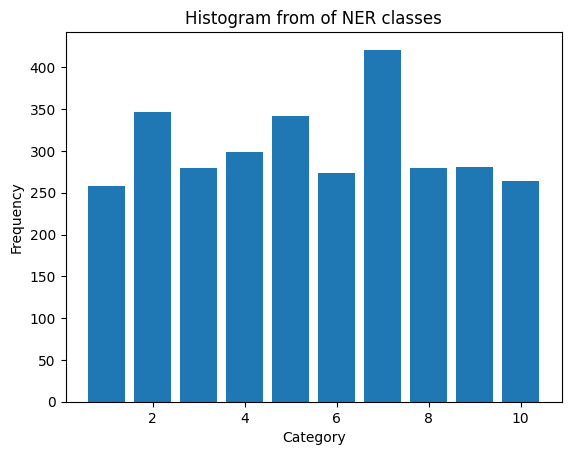

In [6]:
draw_label_hist(animals_synthetic)

In [7]:
import json

with open('./datasets/animal-fun-facts.json', mode="r", encoding='utf8') as f:
    animals_fun_facts = json.load(f)

{9: 87, 6: 117, 2: 168, 10: 55, 5: 202, 3: 32, 7: 36, 4: 81, 1: 4, 8: 24}


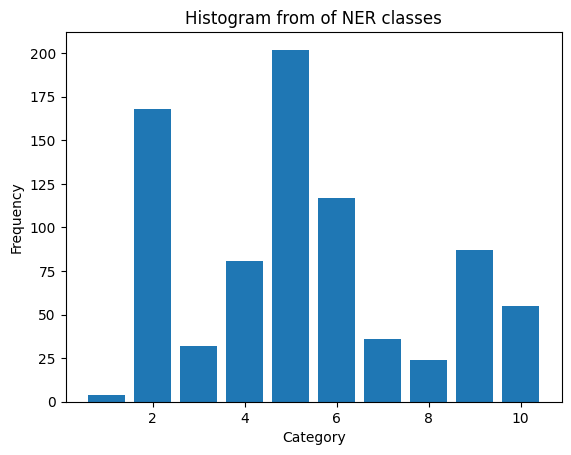

In [8]:
draw_label_hist(animals_fun_facts)

In [9]:
import json

with open('./datasets/coco_animals.json', mode="r", encoding='utf8') as f:
    coco_animals = json.load(f)

{1: 7, 2: 23, 7: 22, 5: 20, 4: 18, 6: 12, 3: 13, 8: 16, 10: 15, 9: 13}


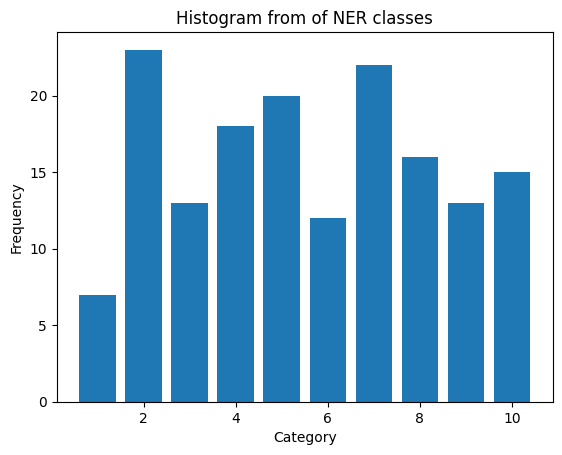

In [10]:
draw_label_hist(coco_animals)

The training data is slightly imbalanced (up to ~30%). I think such small imbalance will not affect model performance dramatically. It's not great, but balance is not so important for transformers in NER tasks.